# Huiswerkopdracht - Boekclassificatie

### Notebook van Esmee Kraan

**Disclaimer**: Stukken code in dit notebook zijn geschreven met ChatGPT, boven deze code staat dit vermeld met de context en wat voor prompt is gebruikt.

---

## Table of contents

1. [Introduction](#Introduction)

2. [The problem domain](#The-problem-domain)

4. [Business Understanding](#Business-Understanding)

5. [Required libraries](#Required-libraries)

6. [Data Understanding](#Data-Understanding)

7. [Data Prepartion](#Data-Preparation)

8. [Modeling](#Modeling)

9. [Evaluation](#Evaluation)

10. [Reproducibility](#Reproducibility)

---

# Introduction

[[ go back to the top ]](#Table-of-contents)

In deze huiswerkopdracht ga ik verder met de technieken die ik heb geleerd tijdens de werkcolleges. We hebben ons toen gericht op sentimentanalyse van IMDB-reviews, en nu ga ik aan de slag met boekteksten van Project Gutenberg. Het doel van deze opdracht is om een neuraal netwerk te bouwen dat kan voorspellen in welk genre een boek zich bevindt, op basis van tekstuele samples van 600 woorden.

---


# The problem domain

[[ go back to the top ]](#Table-of-contents)

Boeken indelen in verschillende genres is belangrijk binnen de literatuur- en informatiekunde. Het maakt het voor lezers veel makkelijker om boeken te vinden die bij hun interesses passen. In dit project gebruik ik tekstuele samples van boeken van Project Gutenberg, die zijn opgedeeld in stukjes van 600 woorden. De genres zijn gecategoriseerd volgens de Library of Congress Classificatie. In het figuur hieronder is te zien wat voor verdeling qua genres in de train-dataset te vinden is.

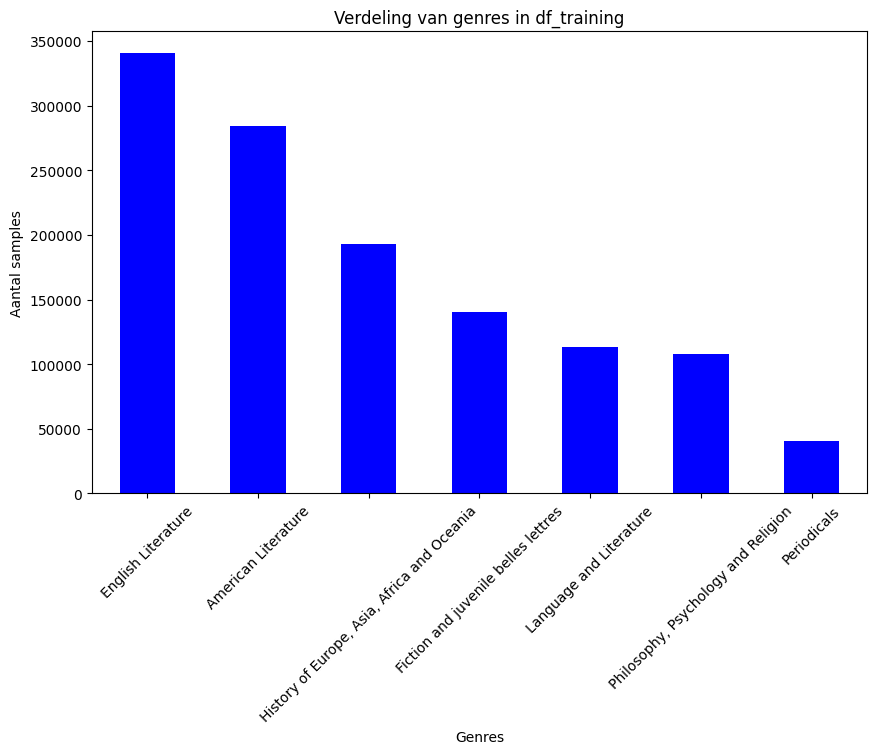

Met meer dan 1,59 miljoen records is het een flinke klus om te bekijken hoe goed mijn model kan voorspellen. Het is wel een uitdaging, vooral omdat de genres niet gelijk verdeeld zijn en er veel variatie is in schrijfstijlen en onderwerpen binnen elk genre.

---

# Business Understanding

[[ go back to the top ]](#Table-of-contents)

Het doel van deze opdracht is om een model te bouwen dat efficiënt en effectief het genre van een boek kan voorspellen aan de hand van de tekst. Dit is waardevol voor bibliotheken, boekwinkels en online platforms, omdat het aanbevelingen aan gebruikers verbetert en zo de klanttevredenheid en verkoop kan verhogen.

**Wat gaan we oplossen?**
> Ik wil een neuraal netwerk ontwikkelen dat het genre van een boek kan voorspellen op basis van de inhoud.

**KSF's van het project?**
> De Kritische Succesfactoren (KSF's) zijn onder andere de nauwkeurigheid van het model, ik doel op een accuracy boven de 50%.

**Kan de vraag opgelost worden met de huidige data?**  
> De data is voldoende om een goed model te trainen, maar ik moet wel rekening houden met de ongelijke verdeling van de genres en de verschillende schrijfstijlen en andere mankementen zoals duplicates en NaN-waarden.

# Vereiste Bibliotheken

[[ go back to the top ]](#Table-of-contents)

Als je Python nog niet op je computer hebt staan, kun je de [Anaconda Python-distributie](http://continuum.io/downloads) gebruiken om de meeste benodigde Python-packages te installeren. Anaconda biedt een eenvoudige installer die je met een dubbelklik kunt gebruiken.

Dit notebook maakt gebruik van verschillende Python-packages die standaard worden meegeleverd met de Anaconda Python-distributie. De belangrijkste bibliotheken die ik zal gebruiken zijn:

* **NumPy**: Biedt een snelle numerieke array-structuur en hulpfuncties.
* **pandas**: Biedt een DataFrame-structuur om gegevens in het geheugen op te slaan en er gemakkelijk en efficiënt mee te werken.
* **scikit-learn**: Het essentiële machine learning-pakket in Python.
* **matplotlib**: Een basis plotbibliotheek in Python; de meeste andere Python-plotbibliotheken zijn hierop gebouwd.
* **Seaborn**: Een geavanceerde bibliotheek voor statistische visualisaties.
* **sounddevice**: Een bibliotheek voor het verwerken en beheren van audiogegevens (indien relevant voor het project).
* **tqdm**: Een bibliotheek voor het maken van voortgangsbalken in loops.

Om ervoor te zorgen dat je alle benodigde packages hebt, kun je ze installeren met `conda` of `pip`:

```bash
conda install numpy pandas scikit-learn matplotlib seaborn tqdm
pip install numpy pandas scikit-learn matplotlib seaborn tqdm
```

In [1]:
# Data Manipulation and Analysis
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

# Visualization
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
from sklearn.metrics import confusion_matrix

# AI packages
import tensorflow as tf  # type: ignore
from tensorflow import keras  # type: ignore
from tensorflow.keras import models, layers
from sklearn.preprocessing import LabelEncoder

# Tokenizer en Padding libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df_val = pd.read_csv('dataset/validation.csv.gz')
df_test = pd.read_csv('dataset/testing.csv.gz')
df_training = pd.read_csv('dataset/training.csv.gz')

# Data Understanding

[[ go back to the top ]](#Table-of-contents)

---

In [66]:
print(df_training.head())
print(df_val.head())
print(df_test.head())

   usage           main genre  \
0  train  American Literature   
1  train  American Literature   
2  train  American Literature   
3  train  American Literature   
4  train  American Literature   

                                               title  samplenumber  \
0  The Works of John Greenleaf Whittier, Volume V...           600   
1  The Works of John Greenleaf Whittier, Volume V...          1200   
2  The Works of John Greenleaf Whittier, Volume V...          1800   
3  The Works of John Greenleaf Whittier, Volume V...          2400   
4  The Works of John Greenleaf Whittier, Volume V...          3000   

                                                 txt  
0  journey more terrible than that of the ideal p...  
1  great struggle for freedom but a soldier of th...  
2  says overrun with superstition on one occasion...  
3  practice of swearing although previously he te...  
4  all manner of uncleanness he would laugh at al...  
        usage           main genre  \
0  validatio

Op t eerste zicht zie ik geen ontbrekende of verkeerde waarde, de datasetes zijn vrij duidelijk ingedeeld met hun usage er zelfs bij vermeld. Maar ik weet nog niet zeker of de dataset schoon is daarom ga ik verder kijken.

In [67]:
print(df_training.info())
print(df_val.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220126 entries, 0 to 1220125
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   usage         1220126 non-null  object
 1   main genre    1220126 non-null  object
 2   title         1220126 non-null  object
 3   samplenumber  1220126 non-null  int64 
 4   txt           1220126 non-null  object
dtypes: int64(1), object(4)
memory usage: 46.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338103 entries, 0 to 338102
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   usage         338103 non-null  object
 1   main genre    338103 non-null  object
 2   title         338103 non-null  object
 3   samplenumber  338103 non-null  int64 
 4   txt           338103 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187969 

In [3]:
df_train = df_training.astype({"txt":"string"})
df_test = df_test.astype({"txt":"string"})
df_val = df_val.astype({"txt":"string"})

Ik zie ook dat elke dataset een `usage` kolom heeft waarin staat of het bedoelt is voor train, test of validatie. Ik wil voor elke df kijken of deze waarde uniek is en er geen andere waarden in zitten.

In [69]:
print(df_training['usage'].unique())
print(df_val['usage'].unique())
print(df_test['usage'].unique())

['train']
['validation']
['test']


ook wil ik in de kolom `main genre` kijken hoe de verdeling van de genres eruitziet, een ongelijke verdeling kan invloed hebben op de prestaties van het model.

In [70]:
print(df_training['main genre'].unique())
print(df_val['main genre'].unique())
print(df_test['main genre'].unique())

['American Literature' 'Fiction and juvenile belles lettres' 'Periodicals'
 'English Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'Language and Literature']
['American Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'English Literature'
 'Fiction and juvenile belles lettres' 'Periodicals'
 'Language and Literature']
['English Literature' 'American Literature' 'Periodicals'
 'Philosophy, Psychology and Religion'
 'Fiction and juvenile belles lettres' 'Language and Literature'
 'History of Europe, Asia, Africa and Oceania']


Verdeling van genres in df_training:
main genre
English Literature                             340450
American Literature                            284157
History of Europe, Asia, Africa and Oceania    193217
Fiction and juvenile belles lettres            140594
Language and Literature                        113459
Philosophy, Psychology and Religion            107821
Periodicals                                     40428
Name: count, dtype: int64


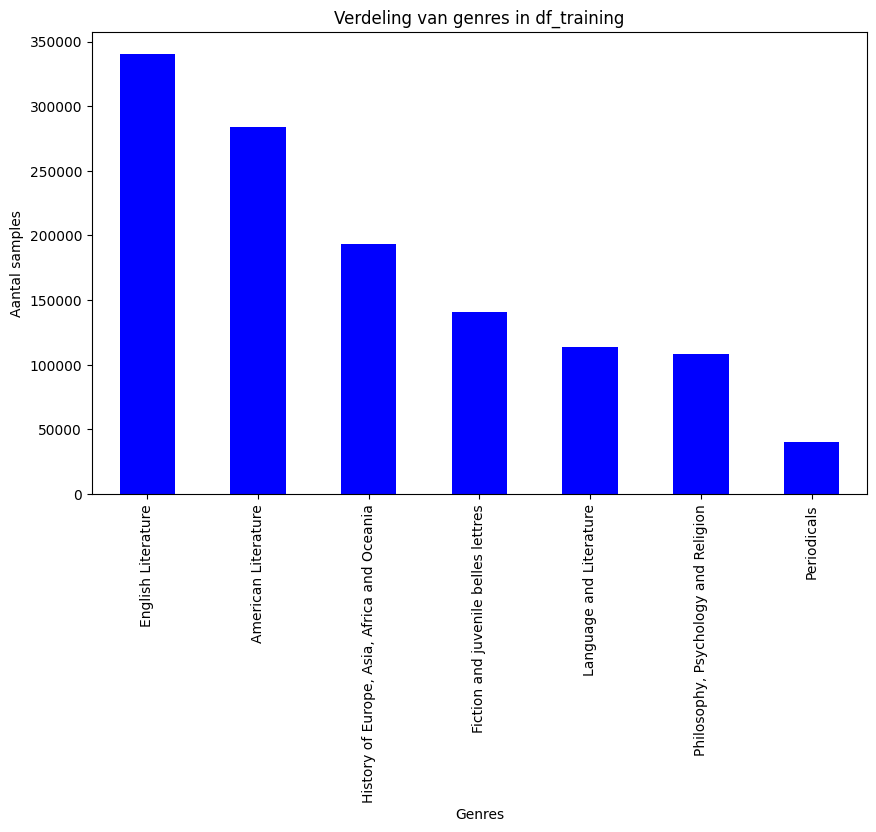

Verdeling van genres in df_val:
main genre
English Literature                             95271
American Literature                            77837
History of Europe, Asia, Africa and Oceania    56577
Fiction and juvenile belles lettres            42770
Language and Literature                        27030
Philosophy, Psychology and Religion            26197
Periodicals                                    12421
Name: count, dtype: int64


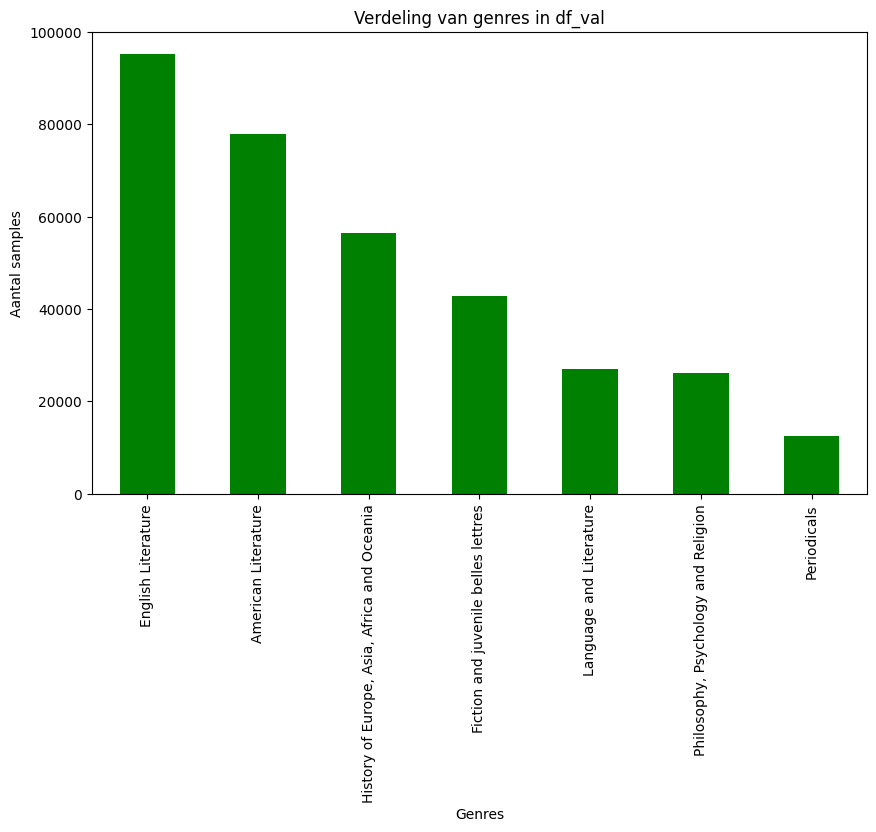

Verdeling van genres in df_test:
main genre
English Literature                             53054
American Literature                            44900
History of Europe, Asia, Africa and Oceania    30921
Fiction and juvenile belles lettres            20782
Language and Literature                        17527
Philosophy, Psychology and Religion            14914
Periodicals                                     5871
Name: count, dtype: int64


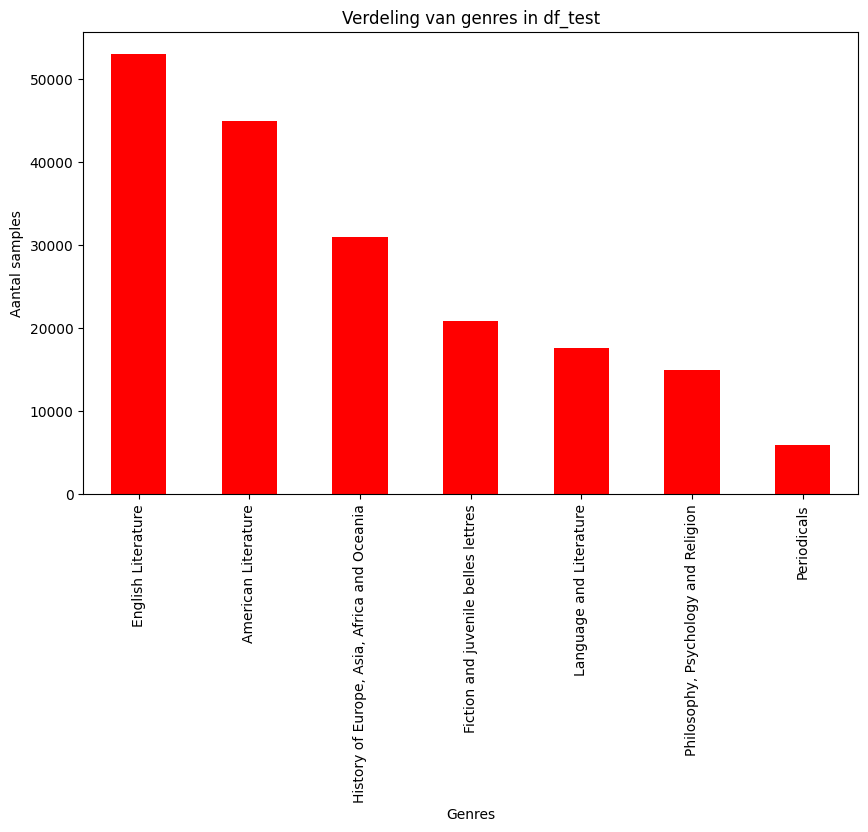

In [71]:
# df_training
print("Verdeling van genres in df_training:")
print(df_training['main genre'].value_counts())

plt.figure(figsize=(10, 6))
df_training['main genre'].value_counts().plot(kind='bar', color='blue')
plt.title('Verdeling van genres in df_training')
plt.xlabel('Genres')
plt.ylabel('Aantal samples')
plt.xticks(rotation=90)
plt.show()

# df_val
print("Verdeling van genres in df_val:")
print(df_val['main genre'].value_counts())

plt.figure(figsize=(10, 6))
df_val['main genre'].value_counts().plot(kind='bar', color='green')
plt.title('Verdeling van genres in df_val')
plt.xlabel('Genres')
plt.ylabel('Aantal samples')
plt.xticks(rotation=90)
plt.show()

# df_test
print("Verdeling van genres in df_test:")
print(df_test['main genre'].value_counts())

plt.figure(figsize=(10, 6))
df_test['main genre'].value_counts().plot(kind='bar', color='red')
plt.title('Verdeling van genres in df_test')
plt.xlabel('Genres')
plt.ylabel('Aantal samples')
plt.xticks(rotation=90)
plt.show()


De verhoudingen tussen genres blijven grotendeels gelijk over de drie datasets, wat goed is voor de representativiteit. In alle datasets zijn de genres in ongeveer dezelfde volgorde van frequentie:

- English Literature is het grootste genre, gevolgd door American Literature en History of Europe, Asia, Africa and Oceania.
- Het kleinste genre is in alle gevallen Periodicals.

Het lijkt erop dat de verdeling al op een consistente manier is gedaan, daarom ga ik er verder niks aan aanpassen.

Dan de kolom `txt` dit is de belangrijkste kolom omdat hier de teksten van elke sample in staan. Daarom ga ik deze kolom ook nog verkennen.

In [72]:
df_training['txt_length'] = df_training['txt'].apply(lambda x: len(x.split()))
df_val['txt_length'] = df_val['txt'].apply(lambda x: len(x.split()))
df_test['txt_length'] = df_test['txt'].apply(lambda x: len(x.split()))
print(df_training['txt_length'].describe())

count    1.220126e+06
mean     5.996347e+02
std      1.416758e+01
min      1.000000e+00
25%      6.000000e+02
50%      6.000000e+02
75%      6.000000e+02
max      6.000000e+02
Name: txt_length, dtype: float64


Ik pak hier voor elke kolom in `txt` de lengte van de tekst. Dit gebeurt door eerst de tekst te splitten op spaties met `x.split()` dit levert een lijst van woorden waarvan ik de lengte pak met `len()`. Het resultaat hiervan is het aan tal woorden in de tekst die wordt opgeslagen in een nieuwe kolom `txt_length` die ik hieronder kan plotten.

Het valt me gelijk op dat de `mean` niet 600 is, dit betekent dat niet elk stuk tekst 600 lang is. Hier moet ik rekening mee houden later en padding aan toevoegen.

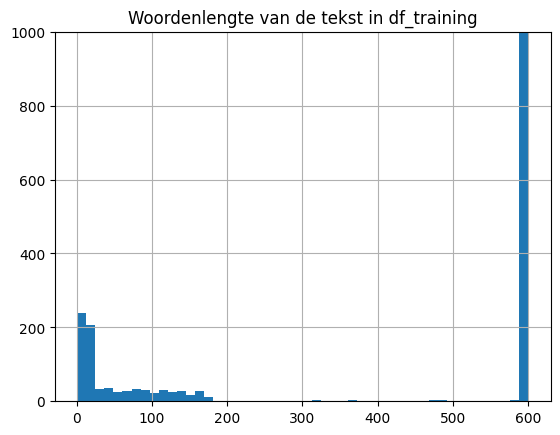

In [73]:
df_training['txt_length'].hist(bins=50)
plt.ylim(0, 1000)
plt.title('Woordenlengte van de tekst in df_training')
plt.show()

In [74]:
print(df_training['txt_length'].unique())

[600  11   4 158  38  12 157 161   1 107  30  94  63  24 349 126   6  43
   8 130  20 111 170 129 326  84 483 138   9  31  21  10 123 186  26   3
  14  17 137  47   5 132  16 155  23 122  13  46 135 103  48 121 124 145
  75  78  22  29  35  92  76 167 139 368  99  56  19  97  18  59 100  72
  55  52   2  54  74  15 159 108 134 146 141  88 115  82   7  69 175  60
 342  91 127  27 479 112  70 169 152 113  98  96  83 136  42 140 106  68
 162 153 420  73 156 591 330  79  93 188  41  45 148  34 173 142  37  86
  77  65 144 133  44  50 508 168  87  67  40 429  89 164 109  33  90 587
 119 110 457 125 150 165  80 172  25 315 149  49  64  62 176 371  61  81
 353 128 120 101  39 105  58 114  32 481  71 147  95  85  66 160 131 116
 324 166 118 171  57 289 117 379 438 586 204 318 498 492 338 259 227 394
 564 577 480 413 258 473 367 317 249 282]


Op de plot en de `.unique()` is te zien dat er dus een aantal rijen zijn waar de `txt` kolom niet 600 woorden bevat. Deze gaan we eruit filteren.

Ik wil alleen de regels behouden waar het aantal woorden 600 zijn. Dat is wat de functie `filter_texts_by_word_count()` doet. Hij bepaalt het aantal woorden in elke tekst door deze op te splitsen op spaties met `len() en split()`.

---

**Note:** Deze functies zijn gemaakt met behulp van ChatGPT, de prompt was om een functie te maken die het aantal woorden in `txt` telt en de rijen waar niet exact 600 woorden in zitten eruit te filteren.

In [4]:
def filter_texts_by_word_count(df, word_limit=600):
    return df[df['txt'].apply(lambda x: len(x.split()) == word_limit)]

In [5]:
df_train_filtered = filter_texts_by_word_count(df_training)
df_val_filtered = filter_texts_by_word_count(df_val)
df_test_filtered = filter_texts_by_word_count(df_test)

Om te kijken of de functie heeft gewerkt check ik nogmaals de `.unique()` op `txt_length`. Als alles goed is gegaan staat hier alleen **600**.

In [182]:
print(df_train_filtered['txt_length'].unique())

[600]


In [183]:
print(df_val_filtered['txt_length'].unique())

[600]


In [184]:
print(df_test_filtered['txt_length'].unique())

[600]


Tot slot wil ik nog op ontbrekende waarden controleren voordat ik de data ga prepareren/ mankementen ga oplossen.

In [185]:
print(df_train_filtered.isnull().sum())
print(df_val_filtered.isnull().sum())
print(df_test_filtered.isnull().sum())

usage           0
main genre      0
title           0
samplenumber    0
txt             0
txt_length      0
dtype: int64
usage           0
main genre      0
title           0
samplenumber    0
txt             0
txt_length      0
dtype: int64
usage           0
main genre      0
title           0
samplenumber    0
txt             0
txt_length      0
dtype: int64


In [186]:
print(df_train_filtered.duplicated().sum())
print(df_val_filtered.duplicated().sum())
print(df_test_filtered.duplicated().sum())

110
0
0


Ik zie wat duplicate waarden in df_training waar ik naar wil kijken.

In [187]:
duplicates = df_train_filtered[df_train_filtered.duplicated(keep=False)]
duplicates.head(10)

,usage,main genre,title,samplenumber,txt,txt_length
77488,train,English Literature,All's Well That Ends Well,1800,practices he hath persecuted time with hope an...,600
77489,train,English Literature,All's Well That Ends Well,2400,so above me in his bright radiance and collate...,600
77491,train,English Literature,All's Well That Ends Well,3600,friend prejudicates the business and would see...,600
77492,train,English Literature,All's Well That Ends Well,4200,steward madam the care i have had to even your...,600
77493,train,English Literature,All's Well That Ends Well,4800,good theres yet one good in ten countess what ...,600
77494,train,English Literature,All's Well That Ends Well,5400,i am thy mother whats the matter that this dis...,600
77495,train,English Literature,All's Well That Ends Well,6600,that you will stay behind us parolles tis not ...,600
77496,train,English Literature,All's Well That Ends Well,7200,king thus he his special nothing ever prologue...,600
77497,train,English Literature,All's Well That Ends Well,7800,damp moist hesperus hath quenchd his sleepy la...,600
77498,train,English Literature,All's Well That Ends Well,8400,scolding quean to a wrangling knave as the nun...,600


Het lijkt erop dat de `txt` kolom geen duplicates bevat maar dat deze gemarkeerd worden als duplicate omdat de waarden in andere kolommen (zoals usage, main genre, en title) ook identiek zijn, kunnen ze als duplicaten worden beschouwd.

# Data Preparation

[[ go back to the top ]](#Table-of-contents)

Bij de data understanding heb ik ontdekt dat de lengte van `txt` in elke kolom niet 600 is. Daarom moeten we in ieder geval padding toevoegen zodat deze allemaal aangevuld worden naar 600 woorden. Ook moeten de woorden getokenized worden zodat ieder woord een eigen integer waarde krijgt.

---

Omdat de Tokenization en Padding vrij intensief zijn op mijn laptop en desktop heb ik een functie gemaakt met ChatGPT die een subset maakt waar de genres ook worden omgezet zodat er van elke genre eveneveel rijen zijn. De prompt was dan ook om een functie te maken die een subset maakt en waar de genres overal evenveel zijn.

In [6]:
import pandas as pd

# Aantal gewenste records in de subset
desired_size = 100000

def create_balanced_subset(df, desired_size):
    # Bepaal de unieke genres en hun aantal
    unique_genres = df['main genre'].unique()
    num_genres = len(unique_genres)

    # Bereken het aantal rijen per genre voor een evenwichtige verdeling
    rows_per_genre = desired_size // num_genres

    # Maak de subset door van elk genre een gelijk aantal rijen te selecteren
    subset = pd.concat(
        [df[df['main genre'] == genre].sample(n=rows_per_genre, random_state=42, replace=True) for genre in unique_genres]
    )

    return subset

# Maak evenwichtige subsets aan voor elke dataset
subset_training_100k = create_balanced_subset(df_train_filtered, desired_size)
subset_val_100k = create_balanced_subset(df_val_filtered, desired_size)

# Bekijk de nieuwe subsets
print("Subset Training Genre Verdeling:")
print(subset_training_100k['main genre'].value_counts())

print("\nSubset Validatie Genre Verdeling:")
print(subset_val_100k['main genre'].value_counts())

Subset Training Genre Verdeling:
main genre
American Literature                            14285
Fiction and juvenile belles lettres            14285
Periodicals                                    14285
English Literature                             14285
Philosophy, Psychology and Religion            14285
History of Europe, Asia, Africa and Oceania    14285
Language and Literature                        14285
Name: count, dtype: int64

Subset Validatie Genre Verdeling:
main genre
American Literature                            14285
Philosophy, Psychology and Religion            14285
History of Europe, Asia, Africa and Oceania    14285
English Literature                             14285
Fiction and juvenile belles lettres            14285
Periodicals                                    14285
Language and Literature                        14285
Name: count, dtype: int64


Nu de datasets wat kleiner zijn én er van elke genre evenveel rijen zijn/ train data dus kan ik de `Tokenization` toepassen en de Padding voorbereiden.

In [7]:
# Stap 1: Tokenization en Padding voorbereiden
max_words = 100000
maxlen = 600

# Tokenizer aanmaken en trainen op de gefilterde train data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(subset_training_100k['txt'])

# Zet de tekst om in tokens en pad de sequences tot maxlen = 600
sequences_train = tokenizer.texts_to_sequences(subset_training_100k['txt'])
padded_train = pad_sequences(sequences_train, maxlen=maxlen)

# Doe hetzelfde voor de validatie dataset
sequences_val = tokenizer.texts_to_sequences(subset_val_100k['txt'])
padded_val = pad_sequences(sequences_val, maxlen=maxlen)

Daarna moeten we `main genre` omzetten naar een getal zodat deze ook in een model kan, dit doe ik met behulp van de `LabelEncoder()` functie van sklearn. Dit geeft een binaire matrix terug waarin welke kolom een genre vertegenwoordigt.`

In [8]:
# Stap 2: Label Encoding voor de genre labels
label_encoder = LabelEncoder()
subset_training_100k.loc[:, 'genre_nr'] = label_encoder.fit_transform(subset_training_100k['main genre'])
subset_val_100k.loc[:, 'genre_nr'] = label_encoder.transform(subset_val_100k['main genre'])

Om te checken of de LabelEncoder goed is gegaan en voor elke genre een nummer is gezet bekijk ik eerst nogmaals alle genres die in elke dataset staan.

In [194]:
# Print de unieke genres per dataset
print(df_train_filtered['main genre'].unique())
print(df_val_filtered['main genre'].unique())

['American Literature' 'Fiction and juvenile belles lettres' 'Periodicals'
 'English Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'Language and Literature']
['American Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'English Literature'
 'Fiction and juvenile belles lettres' 'Periodicals'
 'Language and Literature']


Nu ik weet hoeveel en welke genres er zijn wil ik van elke dataset een rij bekijken voor elke unieke waarde in de nieuwe kolom `genre_nr`. Daarom maak ik snel een subset zonder duplicates om alleen de eerste rij voor elke unieke waarde in `genre_nr` te zien. Dit doe ik voor elke dataframe.

In [196]:
# Bekijk een rij voor elke unieke waarde in 'genre_nr' in subset_training
unique_training_genres = subset_training_100k.drop_duplicates(subset='genre_nr')
print(unique_training_genres[['main genre', 'genre_nr']])

# Bekijk een rij voor elke unieke waarde in 'genre_nr' in df_val_filtered
unique_val_genres = subset_val_100k.drop_duplicates(subset='genre_nr')
print(unique_val_genres[['main genre', 'genre_nr']])

                                          main genre  genre_nr
523016                           American Literature         0
1042747          Fiction and juvenile belles lettres         2
510400                                   Periodicals         5
443278                            English Literature         1
165516           Philosophy, Psychology and Religion         6
767205   History of Europe, Asia, Africa and Oceania         3
199133                       Language and Literature         4
                                         main genre  genre_nr
59011                           American Literature         0
303459          Philosophy, Psychology and Religion         6
337142  History of Europe, Asia, Africa and Oceania         3
58129                            English Literature         1
134774          Fiction and juvenile belles lettres         2
216928                                  Periodicals         5
303560                      Language and Literature         4


Zo weet ik zeker dat elke genre er in zit en een uniek nummer heeft gekregen.

Voordat we de modelling fase ingaan wil ik zeker weten dat alle datasets dezelfde lengte hebben.

In [200]:
print(padded_train.shape)  # Dit zou (99995, 600) moeten zijn
print(subset_training_100k['genre_nr'].shape)  # Dit zou (99995,) moeten zijn
print(padded_val.shape)  # Dit zou (99995, 600) moeten zijn
print(subset_val_100k['genre_nr'].shape)  # Dit zou (99995,) moeten zijn

(99995, 600)
(99995,)
(99995, 600)
(99995,)


# Modeling / Evaluation

[[ go back to the top ]](#Table-of-contents)

Voor de modellerings fase wil ik de modellen van beide werkcollege's toepassen, voor elk model loop ik langs welke layers er in zitten en wat deze doen.

---

# Model 0.0: Eenvoudig model met Dropout en Flatten

Dit eerste model is een simpel neuronaal netwerk wat we gebruiken voor tekstclassificatie. Het maakt gebruik van een embedding-laag en dropout om overfitting te beperken. Het vertaalt de tekst-input naar numeriek, zodat deze door kunnen naar de dropout- en output-lagen om het te classificeren. Een aantal kenmerken van elke laag zijn het volgende:

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie (output_dim=7). Dit helpt het model om relaties tussen woorden te leren.
- **Twee Dropout-lagen:** Toegepast met een ratio van 0.5 en 0.8 om overfitting tegen te gaan.
- **Flattening:** Maakt de data 1-dimensionaal om door de dense laag te voeren.
- **Dense Output Laag:** Maakt gebruik van een softmax-functie om de input toe te wijzen aan één van de 7 categorieën (genres).

In [47]:
model = models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=7, input_length=600),
    layers.Dropout(.5),
    layers.Flatten(),
    layers.Dropout(.8),
    layers.Dense(7, activation='softmax')
])

model.build(input_shape=(None, 600))

model.summary()

c:\Users\esmee\OneDrive\Documents\Projecten\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 600, 7)         │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 600, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │        29,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729,407 (2.78 MB)

 Trainable params: 729,407 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.2868 - loss: 1.7266 - val_accuracy: 0.5017 - val_loss: 1.3205
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.4720 - loss: 1.3528 - val_accuracy: 0.5474 - val_loss: 1.2206
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.5223 - loss: 1.2476 - val_accuracy: 0.5832 - val_loss: 1.1660
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.5597 - loss: 1.1665 - val_accuracy: 0.6056 - val_loss: 1.1190
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.5872 - loss: 1.1173 - val_accuracy: 0.6167 - val_loss: 1.0896
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6059 - loss: 1.0760 - val_accuracy: 0.6271 - val_loss: 1.0725
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.6197 - loss: 1.0481 - val_accuracy: 0.6298 - val_loss: 1.0673
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.6322 - loss: 1

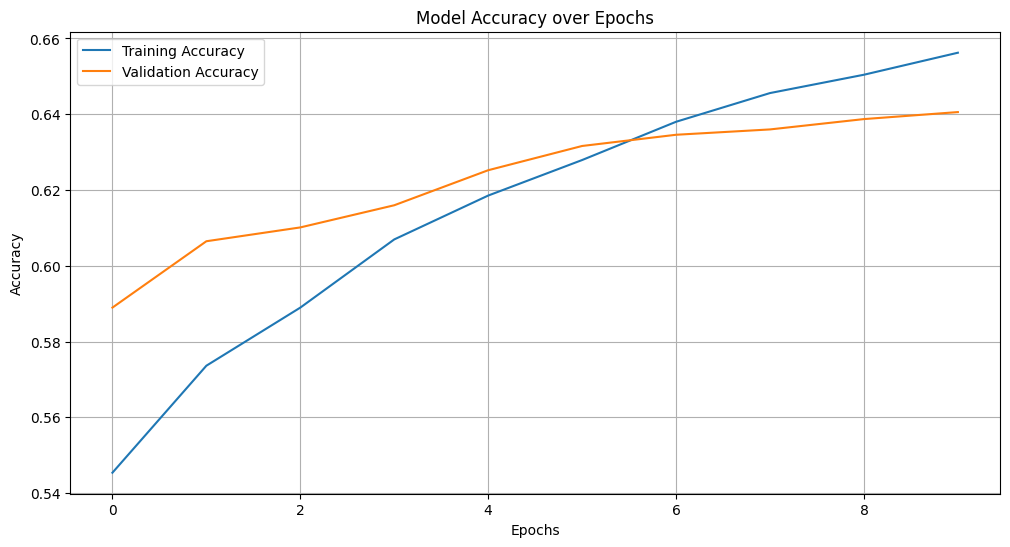

In [211]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit model toont een goede val_acc en ook verbetering over de 10 epochs in vergelijking met sommige andere modellen die zwaar overfit zijn.

- De **val_accuracy** neemt gestaag toe van 58.9% naar 64.06% aan het einde van epoch 10. Dit laat zien dat het model goed leert om de genres in de validatieset te voorspellen.
- Ook de **val_loss** verbetert, van 1.1454 naar 1.0333, wat betekent dat de voorspellingen preciezer worden naarmate het model traint.
- Er is geen grote kloof tussen training en validatieprestaties. De training accuracy is 66% en de val_accuracy is 64%, wat betekent dat het model niet snel overfit lijkt te zijn, ondanks de Dropout-lagen.

Hoewel het model verbetert, blijft de val_loss relatief hoog (1.0333). Desondanks dat dit dus het best presterende model is, er nog steeds ruimte voor een complexer model of andere verfijningen.

---

### Model 0: Neuraal Netwerk met SimpleRNN Layer

Dit model maakt gebruik van een Simple Recurrent Neural Network (SimpleRNN)-laag voor tekstclassificatie. SimpleRNN is een basisvariant van recurrente netwerken die goed werkt voor korte sequenties. Het model is eenvoudig en snel te trainen, maar kan moeite hebben met het onthouden van lange-termijn afhankelijkheden, daarom is dit model niet helemaal toepasselijk voor deze casus, omdat de teksten zo lang zijn vergeet het model op een gegeven moment de hele tekst en kijkt hij alleen naar het laatste stuk.

Belangrijke kenmerken van elke laag:

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie `(output_dim=7)`. Dit helpt het model om relaties tussen woorden te leren.
- **SimpleRNN-laag:** Bevat 32 eenheden en verwerkt de tekstsequenties door ze in volgorde te lezen en te proberen belangrijke context vast te houden. Deze laag is geschikt voor het verwerken van tijdsafhankelijke gegevens zoals tekst.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst in te delen in één van de 7 genres. Dit gebeurt door de waarschijnlijkheden voor elke klasse te berekenen.

In [32]:
# 0. SimpleRNN Model
model_0 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=7, input_length=600),
    keras.layers.SimpleRNN(32, return_sequences=False),
    keras.layers.Dense(7, activation='softmax')
])

model_0.build(input_shape=(None, 600))

model_0.summary()

c:\Users\esmee\OneDrive\Documents\Projecten\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 600, 7)         │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,511 (2.68 MB)

 Trainable params: 701,511 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [230]:
model_0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_0 = model_0.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 345s 109ms/step - accuracy: 0.4914 - loss: 1.3643 - val_accuracy: 0.2420 - val_loss: 1.9915
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 461s 148ms/step - accuracy: 0.5631 - loss: 1.2101 - val_accuracy: 0.2463 - val_loss: 2.0761
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 315s 101ms/step - accuracy: 0.6203 - loss: 1.0776 - val_accuracy: 0.1950 - val_loss: 2.3649
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 261s 84ms/step - accuracy: 0.6611 - loss: 0.9845 - val_accuracy: 0.2442 - val_loss: 2.3577
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 325s 104ms/step - accuracy: 0.6580 - loss: 0.9850 - val_accuracy: 0.2217 - val_loss: 2.5588
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 345s 110ms/step - accuracy: 0.6782 - loss: 0.9509 - val_accuracy: 0.2080 - val_loss: 2.7388
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 261s 83ms/step - accuracy: 0.7408 - loss: 0.7792 - val_accuracy: 0.2278 - val_loss: 2.7758
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 271s 87ms/step - accur

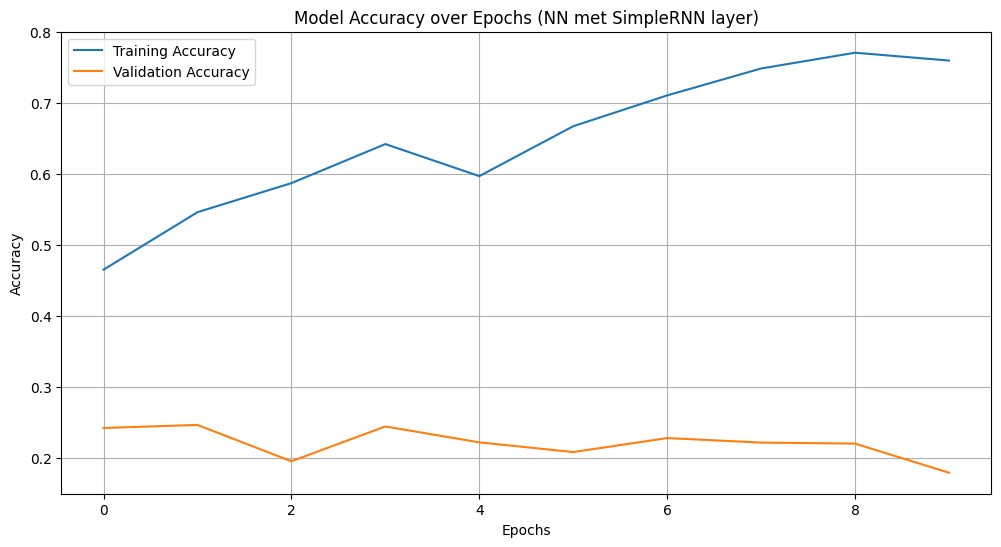

In [231]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_0.history['accuracy'], label='Training Accuracy')
plt.plot(history_0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (NN met SimpleRNN layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit model laat enkele interessante trends zien, maar er zijn duidelijke problemen met de prestaties op de validatieset.

- De training accuracy stijgt fors, van 49.1% in epoch 1 naar 80.8% in epoch 10, wat laat zien dat het model goed leert van de trainingsdata.
- De val_accuracy blijft bijzonder laag, zelfs na 10 epochs. In de eerste epoch is de val_accuracy slechts 24.2%, en deze verslechtert zelfs naar 17.89% aan het einde van epoch 10.
- Het model heeft duidelijk last van overfitting, aangezien de val_loss dramatisch stijgt naar 3.1760, terwijl de training loss laag blijft. Dit betekent dat het model steeds slechter presteert bij het voorspellen van nieuwe data, ondanks dat het beter wordt in het voorspellen van de trainingsdata.

Dit SimpleRNN-model mist het vermogen om goed te generaliseren. Technieken zoals regularisatie, meer dropout, of een geavanceerdere RNN-architectuur zouden kunnen helpen om de prestaties op de validatieset te verbeteren.

---

### Model 1: 1 LSTM Layer

Dit model introduceert een Long Short-Term Memory (LSTM)-laag, een variant van recurrente netwerken die beter geschikt is voor het verwerken van sequenties en het onthouden van lange-termijn afhankelijkheden. LSTM’s zijn effectiever voor tekstclassificatie, vooral wanneer de volgorde van woorden belangrijk is.

Belangrijke kenmerken van elke laag:

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie `(output_dim=7)`. Dit helpt het model om relaties tussen woorden te leren.
- **LSTM-laag:** Bestaat uit 32 eenheden en is speciaal ontworpen om informatie over langere tijd vast te houden in de sequentie. Dit maakt het model krachtiger dan een SimpleRNN voor complexere volgorde-afhankelijke taken zoals tekstclassificatie.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst in te delen in één van de 7 genres. Dit gebeurt door de waarschijnlijkheden voor elke klasse te berekenen.

In [33]:
# 1. LSTM Model met 1 Laag
model_1 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=7, input_length=600),
    keras.layers.LSTM(32),
    keras.layers.Dense(7, activation='softmax')
])

model_1.build(input_shape=(None, 600))

model_1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 600, 7)         │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,351 (2.69 MB)

 Trainable params: 705,351 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_1 = model_1.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 647s 206ms/step - accuracy: 0.2170 - loss: 1.8587 - val_accuracy: 0.2918 - val_loss: 1.7088
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 652s 209ms/step - accuracy: 0.3251 - loss: 1.6654 - val_accuracy: 0.3322 - val_loss: 1.7287
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 652s 209ms/step - accuracy: 0.3803 - loss: 1.5581 - val_accuracy: 0.3442 - val_loss: 1.6285
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 648s 207ms/step - accuracy: 0.3830 - loss: 1.5535 - val_accuracy: 0.3999 - val_loss: 1.5304
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 603s 193ms/step - accuracy: 0.4632 - loss: 1.3495 - val_accuracy: 0.4446 - val_loss: 1.4177
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 698s 223ms/step - accuracy: 0.5697 - loss: 1.1145 - val_accuracy: 0.4802 - val_loss: 1.4013
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 837s 268ms/step - accuracy: 0.6591 - loss: 0.9348 - val_accuracy: 0.5089 - val_loss: 1.3917
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 820s 262ms/step - ac

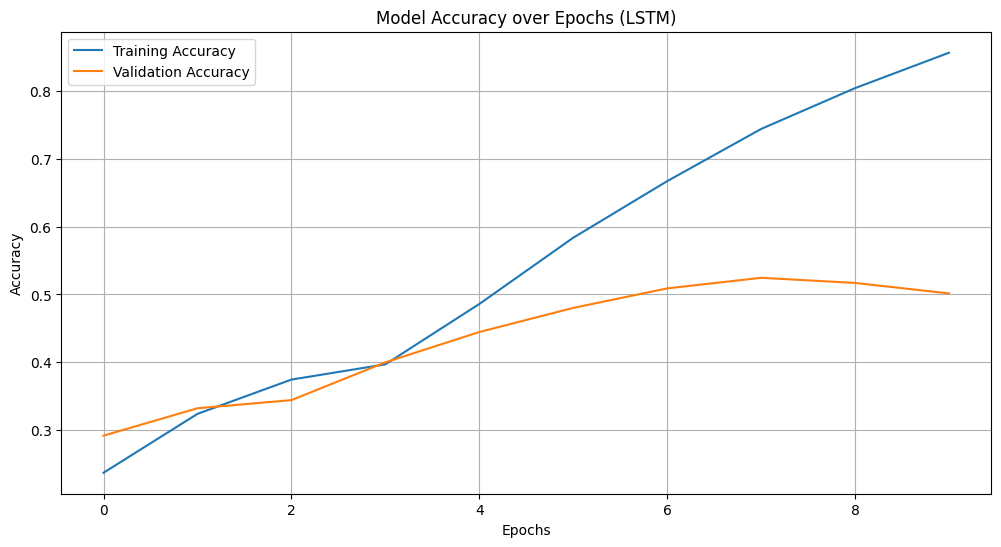

In [11]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit model laat zeker al verbeteringen zien in vergelijking met het RNN-Model, maar er zijn alsnog problemen met de prestaties op de validatieset.

- De training accuracy stijgt fors, van 21.7% in epoch 1 naar 86.15% in epoch 10, wat laat zien dat het model goed leert van de trainingsdata.
- De val_accuracy blijft echter laag, zelfs na 10 epochs. In de eerste epoch is de val_accuracy 29.18%, en deze schommelt rond 50%, zonder verdere significante verbetering naarmate het model doortraint.
- Het model heeft duidelijk last van overfitting, aangezien de val_loss na aanvankelijke verbetering weer begint te stijgen naar 1.7025, terwijl de training loss sterk blijft dalen. Dit betekent dat het model steeds slechter presteert op nieuwe data, ondanks de verbetering op de trainingsdata.

Dit LSTM-model mist het vermogen om goed te generaliseren. Technieken zoals regularisatie, meer dropout, of het toevoegen van Early Stopping zouden kunnen helpen.

---

### Model 2: 2 LSTM Layers

Dit model bestaat uit twee LSTM-lagen, wat het beter zou moeten maken in het verwerken van sequentiële data en het leren van complexe patronen over langere teksten. Door meerdere LSTM-lagen te stapelen, kan het model diepere relaties in de sequenties ontdekken.

Belangrijke kenmerken van elke laag:

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie `(output_dim=64)`. Dit helpt het model om relaties tussen woorden te leren in een hogere dimensionale ruimte, wat meer nuance mogelijk maakt dan kleinere embeddings.
- **Eerste LSTM-laag:** De eerste LSTM-laag bevat 32 eenheden en retourneert de volledige sequentie (met return_sequences=True), wat betekent dat de output van elke tijdstap als input wordt doorgegeven aan de volgende laag.
- **Tweede LSTM-laag:** Deze laag bevat ook 32 eenheden, maar retourneert alleen de laatste output, waardoor het model samenvat wat het over de hele sequentie heeft geleerd.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst in te delen in één van de 7 genres. Dit gebeurt door de waarschijnlijkheden voor elke klasse te berekenen.

In [34]:
# 2. LSTM Model met 2 Lagen
model_2 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=600),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(7, activation='softmax')
])

model_2.build(input_shape=(None, 600))

model_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 600, 64)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 600, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,420,967 (24.49 MB)

 Trainable params: 6,420,967 (24.49 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1720s 549ms/step - accuracy: 0.2197 - loss: 1.8478 - val_accuracy: 0.3417 - val_loss: 1.6471
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1729s 553ms/step - accuracy: 0.3688 - loss: 1.5781 - val_accuracy: 0.4541 - val_loss: 1.4005
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1709s 547ms/step - accuracy: 0.5300 - loss: 1.2379 - val_accuracy: 0.4911 - val_loss: 1.3506
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1704s 545ms/step - accuracy: 0.6357 - loss: 1.0239 - val_accuracy: 0.5435 - val_loss: 1.2760
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1703s 545ms/step - accuracy: 0.7582 - loss: 0.7208 - val_accuracy: 0.5514 - val_loss: 1.3263
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1700s 544ms/step - accuracy: 0.8505 - loss: 0.4749 - val_accuracy: 0.5575 - val_loss: 1.4265
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1237s 396ms/step - accuracy: 0.9123 - loss: 0.2965 - val_accuracy: 0.5572 - val_loss: 1.6344
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 996s 319ms/st

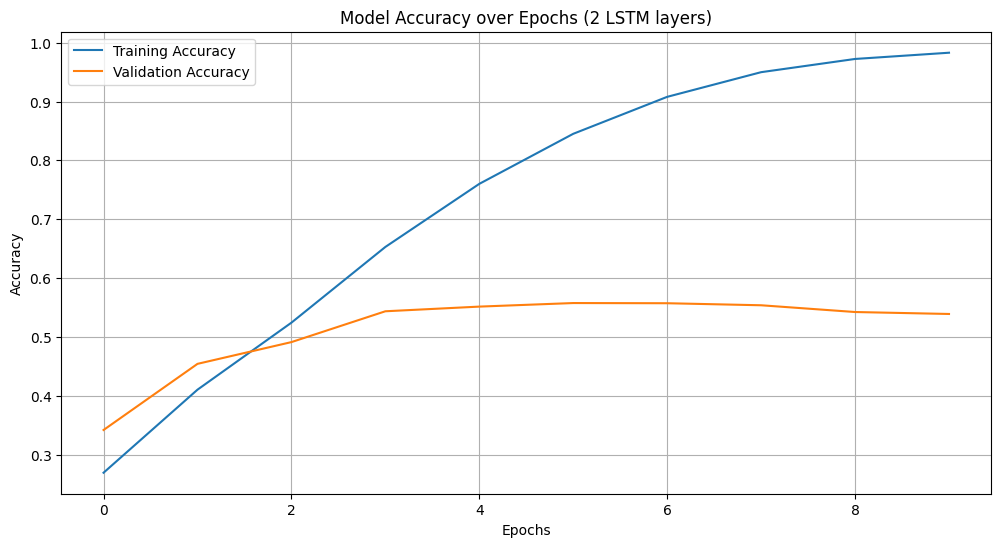

In [14]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (2 LSTM layers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit model laat ook positieve dingen zien, maar heeft ook duidelijke problemen met generalisatie op de validatieset.

- De training accuracy stijgt super snel, van 21.97% in epoch 1 naar een indrukwekkende 98.48% in epoch 10, wat aangeeft dat het model uitstekend leert van de trainingsdata.
- De val_accuracy begint redelijk goed bij 34.17% en piekt rond 55.75%, maar blijft daarna hangen en begint zelfs licht te dalen. Dit toont aan dat het model moeite heeft om de prestaties op nieuwe, ongeziene data te verbeteren.
- De val_loss vertoont een zorgwekkend patroon: terwijl de training loss continu daalt (van 1.84 naar 0.06), stijgt de val_loss drastisch van 1.6471 naar 2.5081 in de laatste epoch. Dit is een duidelijk teken van overfitting—het model presteert steeds beter op de trainingsset, maar verliest de capaciteit om goed te generaliseren naar de validatieset.

Een dropout tussen de LSTM-Lagen zou kunnen helpen om het netwerk beter te regualiriseren. En met Early Stopping kan de training gestopt worden wanneer de val_loss verslechtert.

---

### Model 3: GRU Model met Dropout

Dit model maakt gebruik van Gated Recurrent Units (GRU), een variant van de LSTM, met als voordeel dat het minder zwaar voor je computer zou moeten zijn, maar nog steeds in staat is om sequentiële informatie goed te verwerken. De dropout wordt toegepast om overfitting te beperken.

Belangrijke kenmerken van elke laag:

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie `(output_dim=64)`. Dit helpt het model om relaties tussen woorden te leren in een meer gedetailleerde ruimtelijke representatie.
- **Eerste GRU-laag:** Bestaat uit 32 eenheden en retourneert de volledige sequentie `(return_sequences=True)`, wat betekent dat elke stap in de sequentie een bijdrage levert aan de volgende GRU-laag. Dropout van 0.2 wordt toegepast om overfitting tegen te gaan.
- **Tweede GRU-laag:** Deze laag bevat ook 32 eenheden, maar retourneert alleen de laatste output van de sequentie. Hierdoor kan het model de tekst samenvatten voordat het doorgaat naar de outputlaag.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst in te delen in één van de 7 genres. Dit gebeurt door de waarschijnlijkheden voor elke klasse te berekenen.

In [35]:
# 3. GRU Model met Dropout
model_3 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=600),
    keras.layers.GRU(32, return_sequences=True, dropout=0.2),
    keras.layers.GRU(32),
    keras.layers.Dense(7, activation='softmax')
])

model_3.build(input_shape=(None, 600))

model_3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 600, 64)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 600, 32)        │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,415,975 (24.48 MB)

 Trainable params: 6,415,975 (24.48 MB)

 Non-trainable params: 0 (0.00 B)

In [237]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_3 = model_3.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2456s 781ms/step - accuracy: 0.2786 - loss: 1.7276 - val_accuracy: 0.5006 - val_loss: 1.3035
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2601s 833ms/step - accuracy: 0.6184 - loss: 1.0414 - val_accuracy: 0.5261 - val_loss: 1.3128
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2254s 721ms/step - accuracy: 0.7554 - loss: 0.7182 - val_accuracy: 0.5326 - val_loss: 1.3760
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2626s 840ms/step - accuracy: 0.8456 - loss: 0.4742 - val_accuracy: 0.5384 - val_loss: 1.5220
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2617s 837ms/step - accuracy: 0.9130 - loss: 0.2814 - val_accuracy: 0.5530 - val_loss: 1.6645
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2619s 838ms/step - accuracy: 0.9535 - loss: 0.1560 - val_accuracy: 0.5451 - val_loss: 1.9646
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2625s 840ms/step - accuracy: 0.9741 - loss: 0.0901 - val_accuracy: 0.5471 - val_loss: 2.1658
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2510s 803ms/s

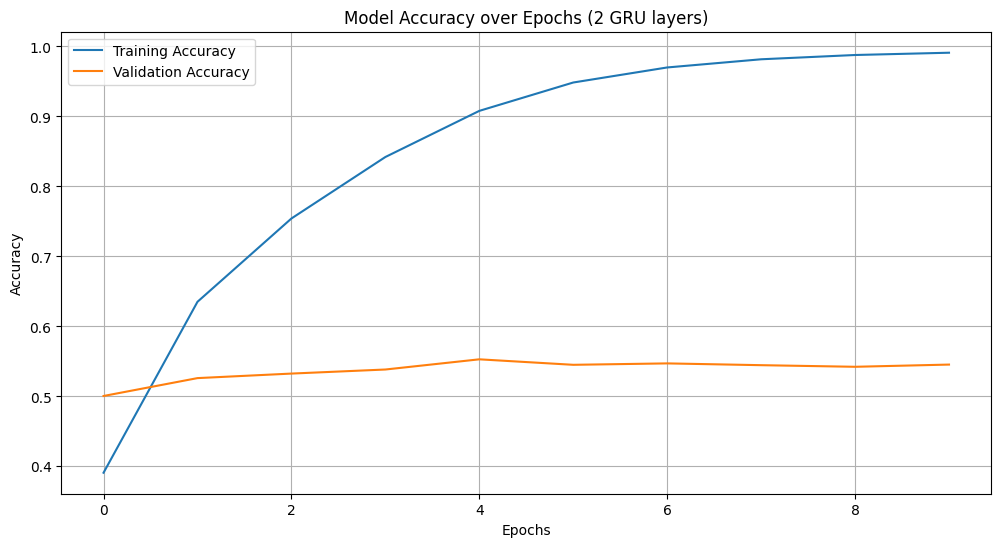

In [238]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (2 GRU layers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit GRU-model met dropout laat enkele positieve aspecten zien, maar ook bij dit model is er sprake van overfitting.

- De training accuracy stijgt weer erg snel en hoog, van 27.86% in epoch 1 naar 99.19% in epoch 10.
- De val_accuracy begint sterk bij 50.06% en blijft stabiel rond de 54-55%, zonder verdere verbetering na de eerste paar epochs. Dit suggereert dat het model moeite heeft om beter te presteren op nieuwe data.
- De val_loss vertoont een duidelijk patroon van overfitting: deze stijgt continu, van 1.3035 in epoch 1 naar 2.8111 in epoch 10. Terwijl de training loss sterk blijft dalen, wijst de stijgende val_loss erop dat het model overmatig geoptimaliseerd is voor de trainingsdata en moeite heeft om te generaliseren naar de validatieset.

Een extra Dropout layer zou helpen bij het voorkomen van snelle overfitting, maar uiteindelijk zou het voor dit model denk ik niet genoeg zijn om het probleem volledig op te lossen. Ook zou Early stopping nuttig zijn bij dit model, eigenlijk vrij wel dezelfde conclusie als de 2 LSTM-Lagen.

---

## Note: Ik heb ervoor gekozen om de bi-directional GRU model eruit te laten (Model 4)

Dit is omdat de resultaten niet erg interessant waren en het model ontzettend lang duurde om te runnen.

---

### Model 5: Convolutioneel Model met Conv1D en MaxPooling

Dit model past een convolutionele architectuur toe, specifiek ontworpen om patronen in sequentiële data zoals tekst te herkennen. Convolutionele netwerken zijn goed in het identificeren van lokale features, zoals n-grammen (groepen van woorden), en maken gebruik van filters om representaties op te bouwen.

Belangrijke kenmerken van elke laag:

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie `(output_dim=64)`. Dit helpt het model om relaties tussen woorden te leren in een rijkere representatieruimte.
- **Eerste Conv1D-laag:** Past 32 filters toe met een kernelgrootte van 3. De convolutionele laag leert lokale patronen in de tekst, zoals woordcombinaties. Het gebruikt ReLU-activatie om niet-lineariteit toe te voegen.
- **MaxPooling1D-laag:** Reduceert de dimensie van de data door de belangrijkste features te selecteren in regio's van 2 woorden `(pool_size=2)`, wat helpt om computationele efficiëntie te verhogen en overfitting te verminderen.
- **Tweede Conv1D-laag:** Verfijnt de features verder door 64 filters toe te passen met een kernelgrootte van 3. Dit helpt om meer complexe patronen te herkennen in de tekst.
- **Flatten-laag:** Zet de meerlagige data om in een 1-dimensionale vector, zodat deze naar de dense output-laag kan worden gevoerd.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst te classificeren in één van de 7 genres.

In [36]:
# 5. Convolutioneel Model met Conv1D en MaxPooling
model_5 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=600),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])

model_5.build(input_shape=(None, 600))

model_5.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 600, 64)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 598, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 299, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 19008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │       133,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,545,447 (24.97 MB)

 Trainable params: 6,545,447 (24.97 MB)

 Non-trainable params: 0 (0.00 B)

In [217]:
model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_5 = model_5.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 189s 60ms/step - accuracy: 0.4789 - loss: 1.3380 - val_accuracy: 0.6097 - val_loss: 1.1269
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 181s 58ms/step - accuracy: 0.8322 - loss: 0.5079 - val_accuracy: 0.5953 - val_loss: 1.3198
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 172s 55ms/step - accuracy: 0.9521 - loss: 0.1552 - val_accuracy: 0.5798 - val_loss: 1.8612
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 160s 51ms/step - accuracy: 0.9842 - loss: 0.0491 - val_accuracy: 0.5795 - val_loss: 2.5491
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 187s 60ms/step - accuracy: 0.9908 - loss: 0.0290 - val_accuracy: 0.5733 - val_loss: 3.1636
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 190s 61ms/step - accuracy: 0.9916 - loss: 0.0250 - val_accuracy: 0.5740 - val_loss: 3.3759
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 161s 52ms/step - accuracy: 0.9930 - loss: 0.0201 - val_accuracy: 0.5681 - val_loss: 3.8152
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 196s 63ms/step - accuracy: 

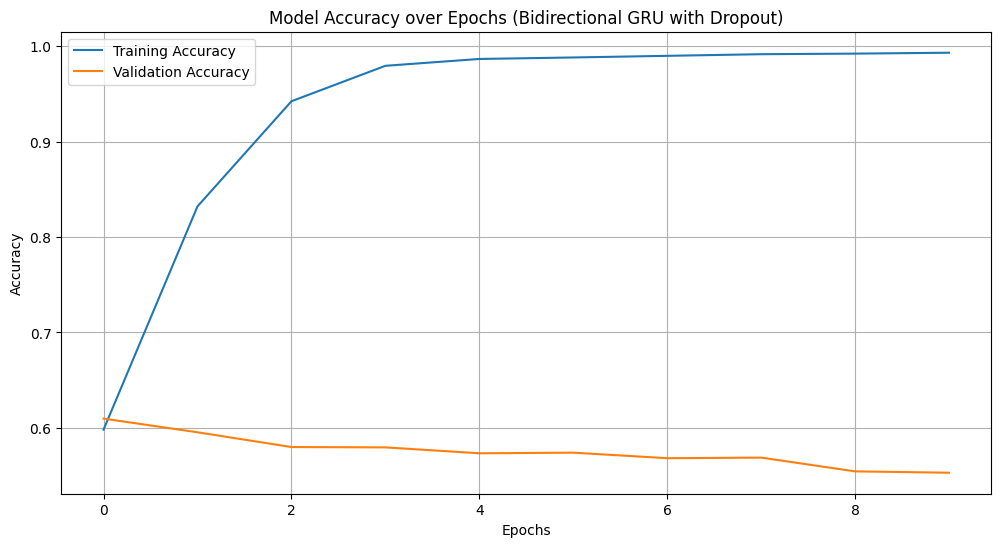

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(history_5.history['accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Bidirectional GRU with Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit convolutionele model met Conv1D en MaxPooling laat een sterke leercurve op de trainingsdata zien, maar vertoont weer tekenen van overfitting en moeite met generalisatie op de validatieset.

- De training accuracy stijgt ook bij dit model snel, van 47.89% in epoch 1 naar 99.48% in epoch 10.
- De val_accuracy begint redelijk goed bij 60.97% in epoch 1, maar verslechtert vervolgens en blijft rond de 55-57% hangen. Ook dit model heeft moeite met verbeteringen bij het voorspellen van nieuwe data.
- De val_loss stijgt ook erg van 1.1269 in epoch 1 naar 5.4379 in epoch 10, ondanks dat de training loss blijft dalen naar bijna nul (0.0155). Deze steeds stijgende val_loss is een sterk teken van overfitting—het model past zich te sterk aan aan de trainingsdata en verliest de mogelijkheid om goed te 

Het convolutionele model met Conv1D en MaxPooling is effectief in het snel leren van patronen in de trainingsdata.

Dit model zou ook profiteren van Dropout om de overfitting beter te gaan en de prestatie op de validatiedataset te verbeteren. Hetzelfde geldt voor het toepassen van Early Stopping.

---

### Model 6: Verbeterde LSTM met Dropout en Bi-directioneel

Dit model is een geavanceerde variant van de LSTM-architectuur die gebruikmaakt van bi-directionaliteit en dropout-technieken om de prestaties bij tekstclassificatie te verbeteren. De bi-directionele structuur stelt het model in staat om informatie zowel van de voor- als achterkant van de sequentie te leren, wat kan leiden tot een betere contextuele interpretatie.

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie `(output_dim=64)`. Het helpt het model om de betekenis van woorden te leren in relatie tot hun context.
- **Eerste Bi-directionele LSTM-laag:** Deze laag, met 32 eenheden en de optie `return_sequences=True`, verwerkt de input sequentieel in beide richtingen. Door het toepassen van dropout (0.2) wordt overfitting verminderd, terwijl het model belangrijke contextuele informatie uit de hele sequentie vastlegt.
- **Tweede Bi-directionele LSTM-laag:** Deze laag heeft ook 32 eenheden en dropout `(0.2)`. Het bouwt voort op de output van de eerste LSTM-laag en helpt om complexere patronen en afhankelijkheden in de tekst vast te leggen.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst in te delen in één van de 7 genres. Dit gebeurt door de waarschijnlijkheden voor elke klasse te berekenen.

In [50]:
# 6. Verbeterde LSTM met Dropout en Bi-directioneel
model_6 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=600),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True, dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, dropout=0.2)),
    keras.layers.Dense(7, activation='softmax')
])

model_6.build(input_shape=(None, 600))

model_6.summary()

c:\Users\esmee\OneDrive\Documents\Projecten\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 600, 64)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 600, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,450,119 (24.61 MB)

 Trainable params: 6,450,119 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_6 = model_6.fit(padded_train, subset_training_100k['genre_nr'], epochs=5, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1440s 459ms/step - accuracy: 0.3082 - loss: 1.6943 - val_accuracy: 0.4024 - val_loss: 1.4955
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1453s 465ms/step - accuracy: 0.4649 - loss: 1.3636 - val_accuracy: 0.4901 - val_loss: 1.3176
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1453s 465ms/step - accuracy: 0.5937 - loss: 1.0866 - val_accuracy: 0.5393 - val_loss: 1.2767
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1425s 456ms/step - accuracy: 0.7266 - loss: 0.7883 - val_accuracy: 0.5830 - val_loss: 1.2180
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1382s 442ms/step - accuracy: 0.8267 - loss: 0.5335 - val_accuracy: 0.5918 - val_loss: 1.3217


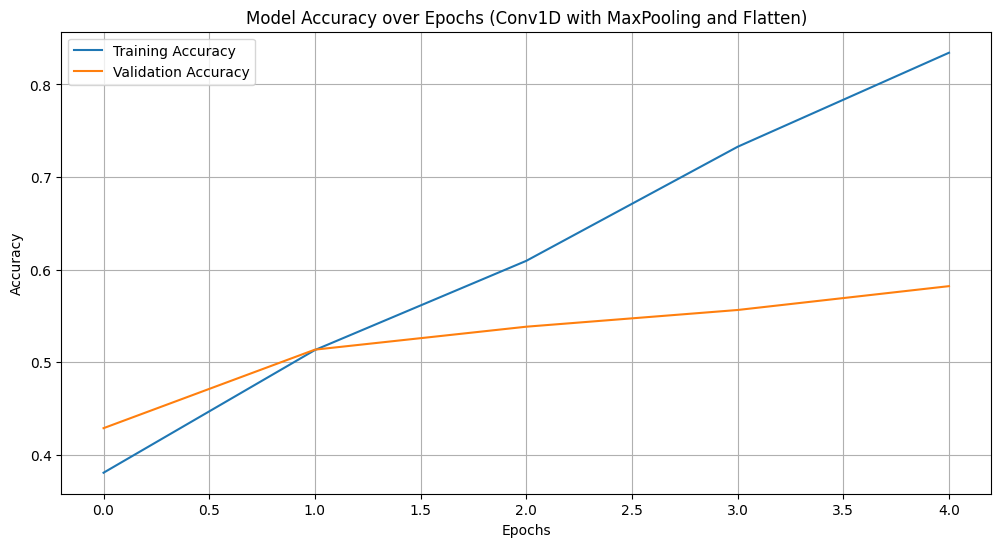

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(history_6.history['accuracy'], label='Training Accuracy')
plt.plot(history_6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Conv1D with MaxPooling and Flatten)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Het verbeterde LSTM-model met dropout en bidirectionele configuratie toont ook een goede leerprogressie en heeft goede prestaties op de trainingsdata. De prestaties op de validatiedata wijzen echter op wel nog een mogelijke overfitting.

- Het model toont een steile verbetering in de trainingsaccuratesse van 37.36% in de eerste epoch tot 83.20% in de laatste epoch.
- De validatie-accuratesse steeg ook, maar minder snel, wat suggereert dit model mogelijk ook niet optimaal generaliseert.
- Het verlies fluctueert in de loop van de epochs, met een piek in het verlies aan het einde (1.3532 in de laatste epoch). Dit kan een indicatie zijn van overfitting, vooral omdat de trainingsaccuratesse blijft stijgen terwijl de validatie-accuratesse stagneert.

De dropout-layer heeft enigzins effect gehad om de overfitting te verminderen, maar niet volledig sinds er nog steeds zeker sprake is van overfitting.

---

### Model 7: Verbeterd Convolutioneel Model met Dropout

Dit model is een verbeterde versie van een convolutioneel neuraal netwerk, waarbij dropout-technieken zijn toegevoegd om overfitting te verminderen en de generalisatiecapaciteit te verbeteren. Dit model maakt gebruik van meerdere convolutionele lagen en max pooling om belangrijke kenmerken uit de tekst te extraheren.

- **Embedding-laag:** Deze laag vertaalt woorden naar vectorrepresentaties met een vaste dimensie (output_dim=64). Dit helpt het model om relaties tussen woorden te leren.
- **Eerste Conv1D-laag:** Met 32 filters en een kernelgrootte van 3, deze laag leert lokale patronen in de sequenties.
- **Eerste MaxPooling-laag:** Vermindert de dimensie van de output van de eerste Conv1D-laag, waardoor alleen de belangrijkste kenmerken behouden blijven.
- **Tweede Conv1D-laag:** Met 64 filters en een kernelgrootte van 3, deze laag leert nog complexere kenmerken uit de data.
- **Tweede MaxPooling-laag:** Vermindert de dimensie van de output van de tweede Conv1D-laag, wat helpt bij het extraheren van de belangrijkste kenmerken.
- **Dropout-laag:** Met een dropout-rate van 0.2 helpt deze laag om overfitting te verminderen door willekeurig een deel van de neuronen uit te schakelen tijdens het trainen.
- **Flattening:** Maakt de data 1-dimensionaal om door de dense laag te voeren.
- **Dense Output Laag:** Gebruikt een softmax-functie om de tekst in te delen in één van de 7 genres. Dit gebeurt door de waarschijnlijkheden voor elke klasse te berekenen.

In [38]:
# 7. Verbeterd Convolutioneel Model met Dropout
model_7 = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=600),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])

model_7.build(input_shape=(None, 600))

model_7.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 600, 64)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 598, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 299, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 297, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │        66,311 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,478,695 (24.71 MB)

 Trainable params: 6,478,695 (24.71 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_7 = model_7.fit(padded_train, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val, subset_val_100k['genre_nr']))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 165s 52ms/step - accuracy: 0.4627 - loss: 1.3554 - val_accuracy: 0.6057 - val_loss: 1.1250
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 167s 53ms/step - accuracy: 0.8219 - loss: 0.5346 - val_accuracy: 0.6001 - val_loss: 1.2944
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 163s 52ms/step - accuracy: 0.9354 - loss: 0.2008 - val_accuracy: 0.5837 - val_loss: 1.8053
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 166s 53ms/step - accuracy: 0.9773 - loss: 0.0716 - val_accuracy: 0.5651 - val_loss: 2.4715
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 160s 51ms/step - accuracy: 0.9859 - loss: 0.0433 - val_accuracy: 0.5776 - val_loss: 2.8854
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 166s 53ms/step - accuracy: 0.9888 - loss: 0.0342 - val_accuracy: 0.5637 - val_loss: 3.6102
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 164s 53ms/step - accuracy: 0.9906 - loss: 0.0282 - val_accuracy: 0.5616 - val_loss: 3.8588
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 171s 55ms/step - accuracy: 

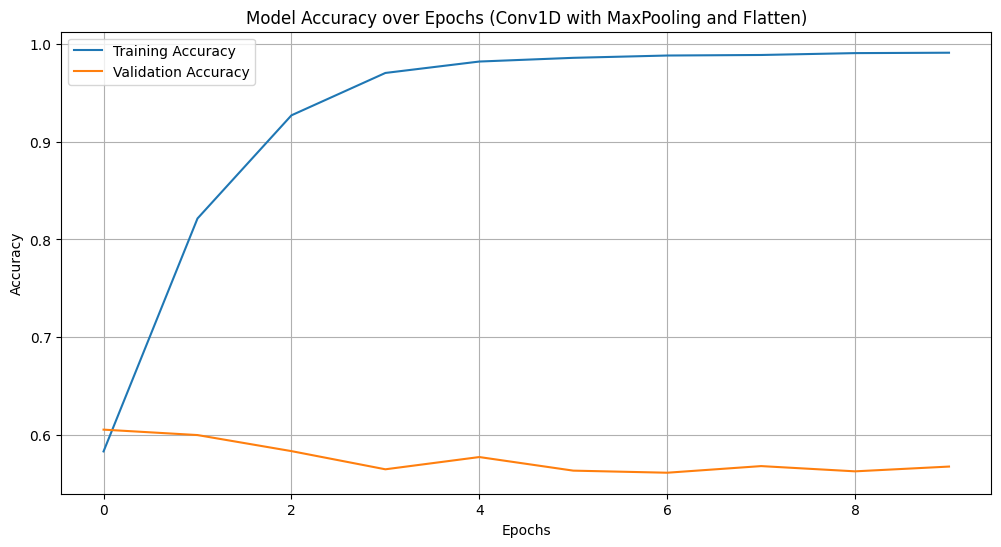

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history_7.history['accuracy'], label='Training Accuracy')
plt.plot(history_7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Conv1D with MaxPooling and Flatten)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Dit verbeterde convolutionele model met Dropout heeft alsnog last van overfitting, ondanks dat het model in het begin goed lijkt te presteren.

- Training accuracy stijgt alweer heel erg, van 46.27% in epoch 1 naar boven de 98% in latere epochs.
- Val_accuracy begint redelijk sterk bij 60.57% in epoch 1, maar neemt daarna geleidelijk af en stabiliseert rond de 56-58%. Dit geeft aan dat het model niet verder verbetert op de validatieset.
- Val_loss vertoont een weer een stijgende trend, van 1.1250 in epoch 1 tot boven de 2.8854 in latere epochs. Deze stijgende val_loss, ondanks de lage training loss, wijst op overfitting—het model past zich te veel aan de trainingsdata aan en presteert slechter op de validatieset.

De toevoeging van dropout heeft zeker enige bescherming tegen vroege overfitting geboden, maar niet genoeg om het probleem volledig te voorkomen zoals verwacht. Het verhogen van de dropout-rate kan helpen om de generalisatie verder te verbeteren, hetzelfde geldt om weer Early Stopping toe te voegen.

---

# Evaluation 

[[ go back to the top ]](#Table-of-contents)

Ik heb ervoor gekozen om alle modellen van de werkcolleges te runnen voor dit huiswerk. In totaal heeft het best wat uren geduurt om dit te runnen, ik heb eerst elk model getest op 3 epochs en een subset van 10k rows. Ik vond dat elk model wel interessante resultaten had, daarom heb ik ze daarna allemaal nog op 10 epochs en een subset van 100k rows gerund. Hoewel het interessant was om de modellen op deze manier te bestuderen kost dit wel immens veel tijd. Daarom ga ik in de toekomst wellicht maar 2-3 modellen runnen op een grote dataset/ met veel epochs. Puur omdat het echt veel tijd kost voor mijn laptop en computer om dit te runnen.

---

Om alle modellen te evalueren kan er gekeken worden naar de (val)acc. Maar in de opdracht stond ook om een confusion matrix te maken om te kijken hoe goed het model bepaalde genres voorspelt. Dat gaan we daarom voor alle modellen doen. Omdat ik in totaal 9 modellen heb die ik ga evalueren heb ik een functie opgesteld om het model te evalueren en in een confusion matrix te zetten. Deze is mede-geschreven door ChatGPT waar code van het huiswerk liet zien om een model te evalueren/ een cm van te maken en dat hij hier twee functies van heeft gemaakt.

In [25]:
def evaluate_model(model, padded_val, true_labels, subset_val_100k):
    # Evaluatie van model op de validatieset
    loss, accuracy = model.evaluate(padded_val, true_labels)

    # Print de resultaten
    print(f"Validation Loss: {loss}")
    print(f"Validation Accuracy: {accuracy}")

    # Haal de unieke genre namen uit de 'main genre' kolom
    genre_labels = subset_val_100k['main genre'].unique()

    # Voorspellingen voor de validatieset
    predictions = model.predict(padded_val)
    predicted_genres = np.argmax(predictions, axis=1)

    # Creëer en visualiseer de confusion matrix
    cm = confusion_matrix(true_labels, predicted_genres)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)  # type: ignore
    plt.xlabel("Voorspelde genres")
    plt.ylabel("Werkelijke genres")
    plt.title("Confusion Matrix voor Genre Voorspellingen")
    plt.show()


<div class="alert alert-block alert-danger"><b>Note:</b> Mijn PC is sommige modellen vergeten, daarom heb ik ook niet van alle 7 een CM. Model 0.0 en Model 6 hadden de meeste potentie en de minste overfitting, daarom heb ik van die 2 het model nogmaals gerund en een CM gemaakt</div>

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 978us/step - accuracy: 0.6305 - loss: 1.0198
Validation Loss: 1.044859766960144
Validation Accuracy: 0.6354217529296875
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


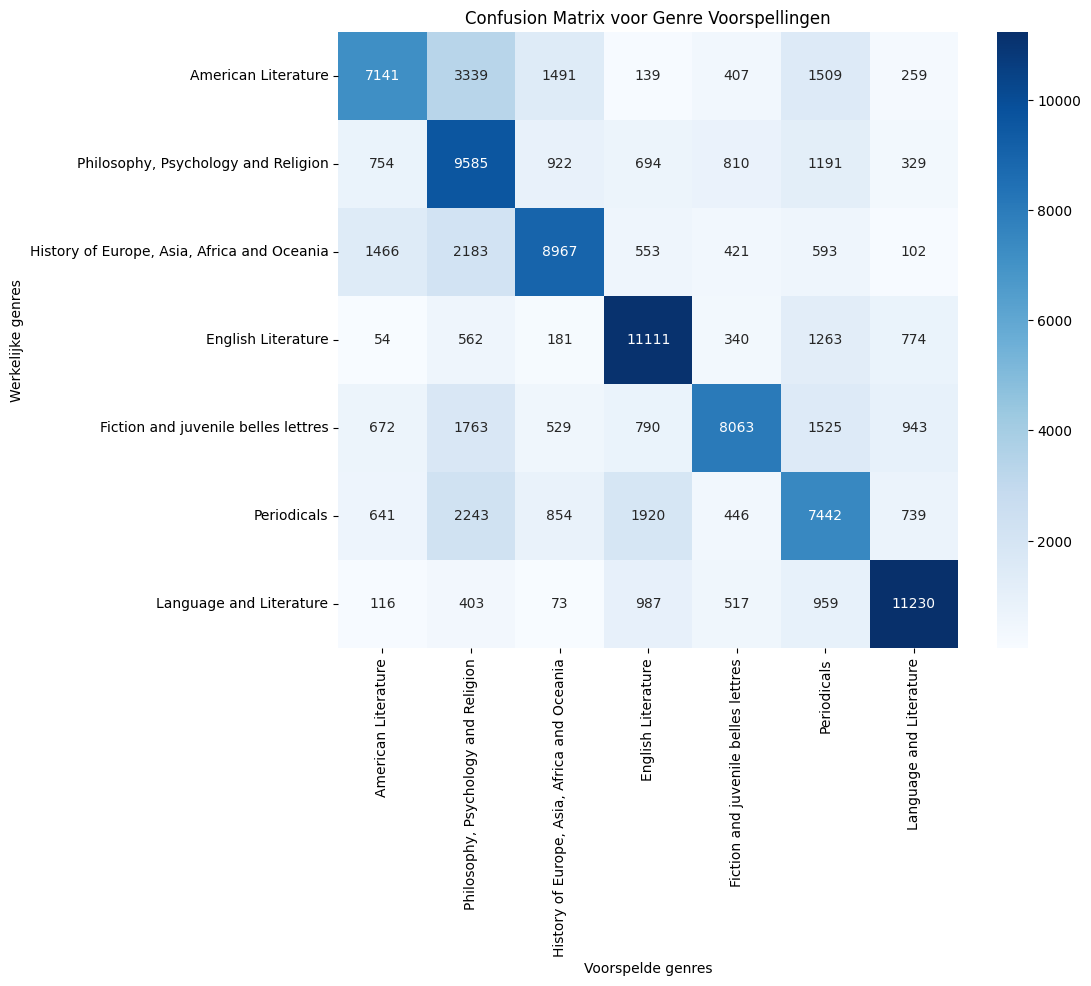

In [52]:
evaluate_model(model, padded_val, subset_val_100k['genre_nr'], subset_val_100k)

`English Literature` en `Language and Literature` doen het het beste bij dit model. Mijn gok is dat dit komt omdat beide genres een specifieke toon en manier van schrijven hebben, vaak een deftige manier. En omdat het Engelse alfabet soms andere woorden heeft in tegendeel tot het "Amerikaans", een goed voorbeeld hiervan is *color vs colour*.

`Philosophy, Psychology and Relgion` worden ook goed voorspeeld. Dit kan komen omdat je met religieuze teksten vaak praat over een "boegbeeld" of leider. Ook zullen er vast veel leefpatronen, regels etc. in deze teksten staan die het model goed kan herkennen.

`American Literature` en `Periodicals` worden het slechtst voorspeld, dit kan komen omdat de teksten in deze genre vrij algemeen zijn en niet een specifiek patroon of thema hebben wat de andere genres wel hebben.

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2067s 661ms/step - accuracy: 0.6077 - loss: 1.2102
Validation Loss: 1.3216726779937744
Validation Accuracy: 0.5917795896530151
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 238s 76ms/step


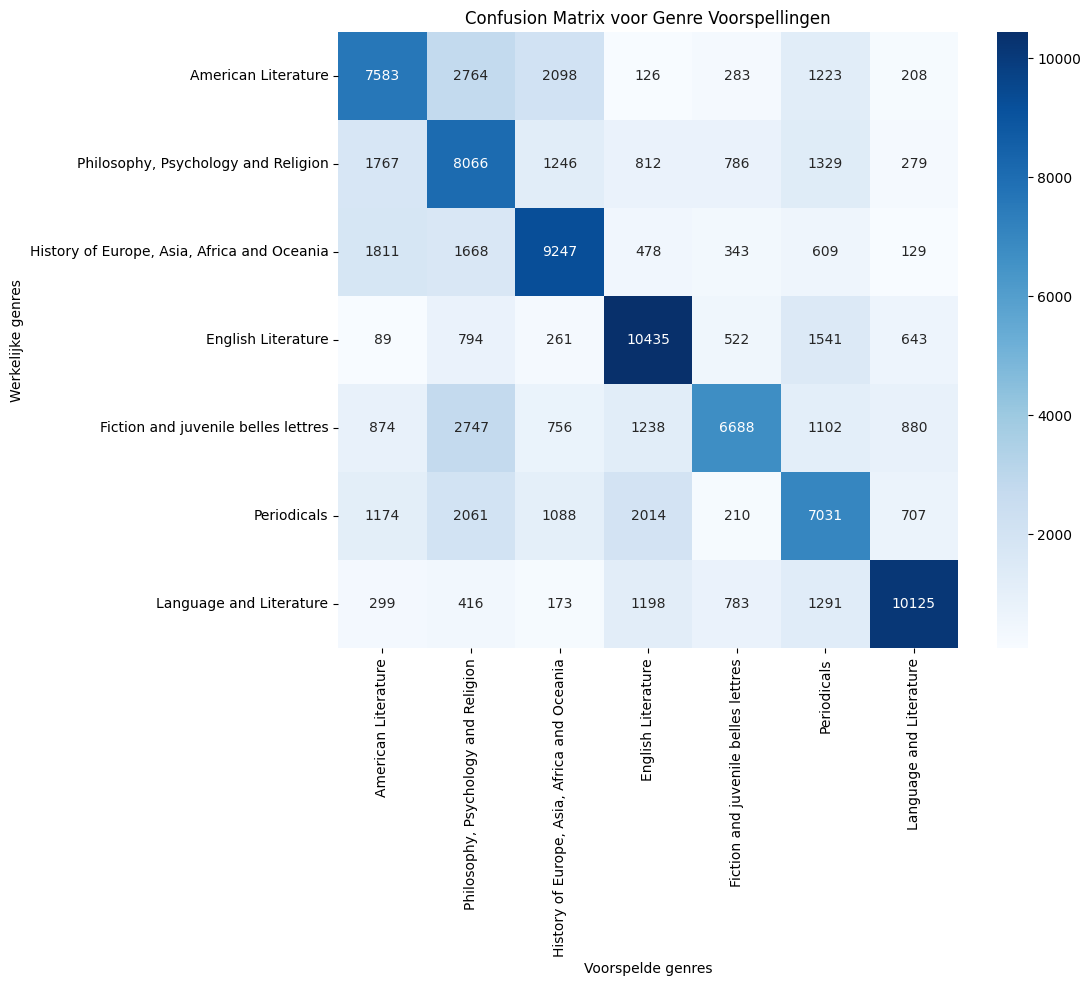

In [53]:
evaluate_model(model_6, padded_val, subset_val_100k['genre_nr'], subset_val_100k)

De resultaten van dit model komen grotendeels overeen met model 0.0, alleen heeft dit model meer moeite met `Fiction and juvenile belles letters`. Ik heb zo snel zelf geen verklaring waarom dit zou zijn.

## Algemene Conclusie

Ik heb ervoor gekozen om voor de huiswerk-opgave te expirementen met verschillende modellen voor tekstclassificatie. Een aantal kwamen uit de werkcolelge's en andere waren vrij simpele modellen om te kijken wat het verschil qua prestatie zou zijn.

Allereerst ga ik deze aanpak niet nog een keer doen bij een volgende huiswerk opgave. Ik heb niet genoeg ge-experimenteerd met een kleinere dataset, ik ging vrijsnel gelijk naar 100K rijen en 10 epochs. In het vervolg wil ik daarom eerst goed expirementeren met een kleinere dataset om te kijken wat de potentie van elk model is. 

De resultaten varieren van een lage accuracy tot een redelijk hoge accuracy, de hoogste die ronde de 64% zit. En hier zijn een aantal algemene observaties die ik heb opgedaan:

**Eenvoudige Modellen:**
- Model 0.0 heeft de beste algemene prestatie getoond met de hoogste val_acc van ongeveer 64% en een algemene acc van 66%. Dit is ook het model met het minste last van overfitting wat waarschijnlijk komt omdat het juist zo'n eenvoudig model is. Het heeft minder parameters, waardoor het moeilijker wordt om de trainingdata te "onthouden" of ruis te leren.
Het RNN-Model toont de slechste resultaten zoals verwacht. Het model heeft veel moeite met tekst onthouden en kijkt vaak alleen naar de laatste stukken, het is daarom ook niet gek waarom de prestatie zo slecht is.

**LSTM- en GRU-modellen:**
- De LSTM-modellen (Model 1 en Model 2) lieten een betere convergentie zien in vergelijking met SimpleRNN. Model 2, met 2 LSTM-lagen, had een maximale nauwkeurigheid van 98%, maar de val_acc was een stuk lager omdat het model veel last heeft van overfitting.
Model 3 (GRU) liet enige verbetering zien in de trainingsnauwkeurigheid, maar had ook last van een lagere val_acc en overfitting. Het GRU-Model was dus enigzins wat beter maar had ook last van overfitting.

**Convolutionele Modellen:**
- Model 5 en Model 7, met convolutielaagstructuren, tonen aan dat convolutionele netwerken goed presteren voor tekstclassificatie. Model 5 had een maximale trainingsnauwkeurigheid van 99%, maar de validatie-accuratesse fluctuëerde ook. Model 7 met Dropout had een vergelijkbare trend, maar met een licht verminderde nauwkeurigheid door het gebruik van Dropout, wat belangrijk kan zijn om overfitting te beperken.

---

## Aanbevelingen voor Vervolgstappen
Als ik deze huiswerk-opgave nog een keer had gedaan had ik zeker gebruik gemaakt van een batchsizing/ verwerksysteem. Dan had ik de modellen namelijk kunnen trainen op een grotere dataset wat wellicht effect had kunnen hebben op de resultaten. Nu werkte ik namelijk maar met een deel van de hele dataset (100k Rows).

Ook omdat ik te snel met een te grote dataset ben gaan experimenteren was het lastig om snel een model nogmaals te draaien met bijvoorbeeld L2-regularisatie, meer dropout/ flatten-lagen en batchnormalisatie. Dit zou ik in het vervolg anders doen door klein te beginnen.

# Deployment

[[ go back to the top ]](#Table-of-contents)

Zoals ik al bij de algemene conclusie zei, als dit model in de praktijk uitgevoerd zou worden raad ik sterk aan om een batch-verwerkingssysteem op te zetten. Zo kan je redelijk efficiënt data verwerken en dingen tegelijkertijd voorspelleing, in plaats van één voor één. Ook verminderd het de kans op mogelijke crashes vanwege grote hoeveelheden data.

Het is sowieso verstandig om rekening te houden met de grootte van het model en benodigde extra's zoals de datasets. Bij het draaien van de LSTM- en GRU-Netwerken merkte ik al dat mijn laptop én desktop hier veel moeite mee hadden omdat het veel geheugen en rekenkracht vereist. Dit kan voor problemen zorgen in een omgeving met beperkte resources.

---